 # Denoising Diffusion Implicit Models -- DDIM

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from fastprogress.fastprogress import progress_bar

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

Generating test split: 100%|██████████| 10000/10000 [00:01<00:00, 5719.36 examples/s]


In [5]:
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

 ## Diffusers DDPM Scheduler

In [6]:
# We have our model trained in miniai that we wrapped in UNet and overrode the forward method to return the `.sample()`.
# Using diffusers here we can't do that, it expects it as it should be in the original class. So, we can just create
# class to wrap it to do nothing, so that we can still torch.load without complaints
class UNet(UNet2DModel): pass

In [7]:
model = torch.load('../models/fashion_ddpm3_25.pkl', map_location=torch.device(def_device))

In [8]:
sched = DDPMScheduler(beta_end=0.01)

In [9]:
x_t = torch.randn((32, 1, 32, 32)).to(def_device)

In [10]:
t = 999
t_batch = torch.full((len(x_t),), t, device=x_t.device, dtype=torch.long)
with torch.no_grad(): noise = model(x_t, t_batch).sample

In [11]:
res = sched.step(noise, t, x_t)
res.prev_sample.shape

torch.Size([32, 1, 32, 32])

In [12]:
%%time
sz = (2048, 1, 32, 32)
x_t = torch.randn(sz).to(def_device)
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())

CPU times: user 15min 39s, sys: 4.11 s, total: 15min 44s
Wall time: 15min 43s


In [13]:
s = preds[-1].clamp(-0.5,0.5)*2

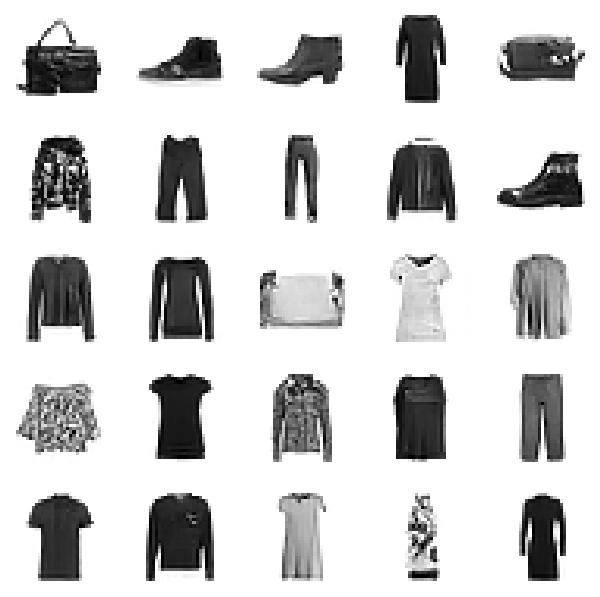

In [14]:
show_images(s[:25], imsize=1.5)

In [15]:
cmodel = torch.load('../models/data_aug2.pkl', map_location=def_device)
# cmodel = torch.load('/content/data_aug2.pkl', map_location=def_device)
del(cmodel[8])
del(cmodel[7])

In [16]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

In [17]:
ie.fid(s),ie.kid(s)

(4.525634765625, 0.038088832050561905)

In [18]:
ie.fid(xb),ie.kid(xb)

(1.34619140625, -0.014551813714206219)

 ## Diffusers DDIM Scheduler

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [13]:
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(333)

In [14]:
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).to(def_device)
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds

In [16]:
sz = (2048, 1, 32, 32)

In [17]:
# eta param determines how much of the noise that the schedule says should be added is added
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1] * 2).clamp(-1, 1)

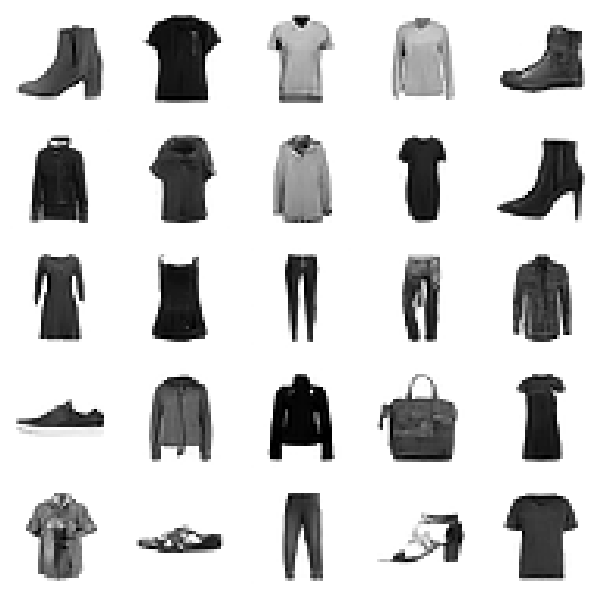

In [18]:
show_images(s[:25], imsize=1.5)

In [19]:
ie.fid(s),ie.kid(s)

(7.65673828125, 0.04525128751993179)

7.7000732421875 0.04364575445652008


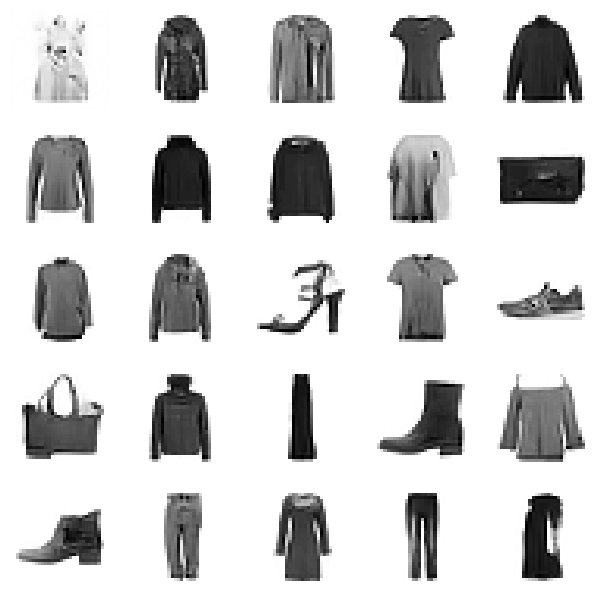

In [20]:
sched.set_timesteps(200)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
print(ie.fid(s),ie.kid(s))
show_images(s[:25], imsize=1.5)

14.7694091796875 0.09688420593738556


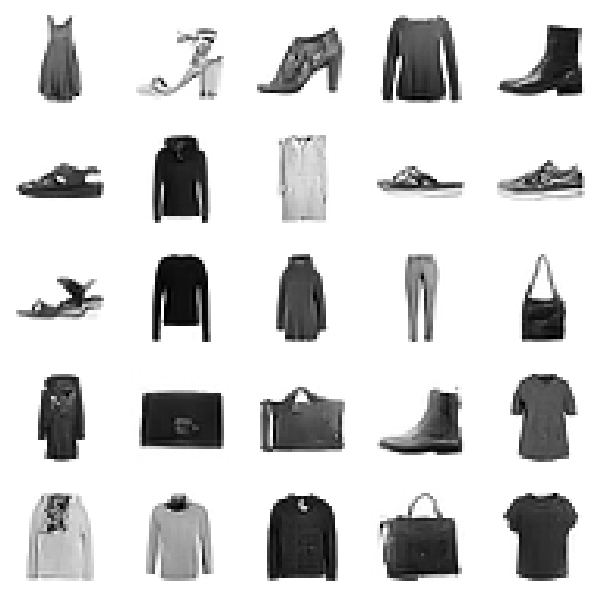

In [21]:
sched.set_timesteps(100)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
print(ie.fid(s),ie.kid(s))
show_images(s[:25], imsize=1.5)

21.22607421875 0.165159672498703


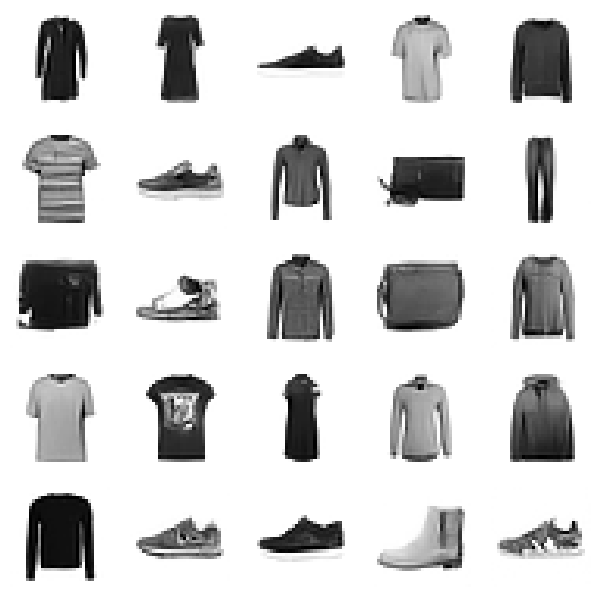

In [22]:
sched.set_timesteps(50)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
print(ie.fid(s),ie.kid(s))
show_images(s[:25], imsize=1.5)

35.407958984375 0.27443742752075195


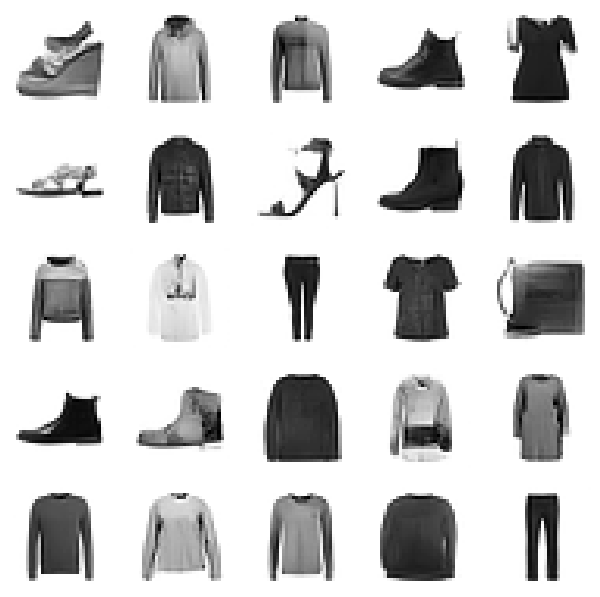

In [23]:
sched.set_timesteps(25)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
print(ie.fid(s),ie.kid(s))
show_images(s[:25], imsize=1.5)

 ## Implementing DDIM

In [24]:
from types import SimpleNamespace

In [25]:
n_steps = 1000

In [26]:
def linear_sched(betamin=0.0001, betamax=0.02, n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [27]:
sc = linear_sched(betamax=0.01, n_steps=n_steps)
abar = sc.abar

 pull out the single step function from the DDIM scheduler

In [31]:
def ddim_step(x_t, t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta):
    vari = ((bbar_t1 / bbar_t) * (1 - abar_t / abar_t1))
    sig = vari.sqrt() * eta
    x_0_hat = ((x_t - bbar_t.sqrt() * noise) / abar_t.sqrt())
    x_t = abar_t1.sqrt() * x_0_hat + (bbar_t1 - sig**2).sqrt() * noise
    if t > 0: x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_t

In [32]:
@torch.no_grad()
def sample(f, model, sz, n_steps, skips=1, eta=1.):
    tsteps = list(reversed(range(0, n_steps, skips)))
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i, t in enumerate(progress_bar(tsteps)):
        abar_t1 = abar[tsteps[i+1]] if t > 0 else torch.tensor(1)
        noise = model(x_t, t).sample
        x_t = f(x_t, t, noise, abar[t], abar_t1, 1-abar[t], 1-abar_t1, eta)
        preds.append(x_t.float().cpu())
    return preds

In [33]:
%%time
samples = sample(ddim_step, model, sz, n_steps, 10)

CPU times: user 1min 34s, sys: 43.3 ms, total: 1min 34s
Wall time: 1min 34s


13.712158203125 0.08081326633691788


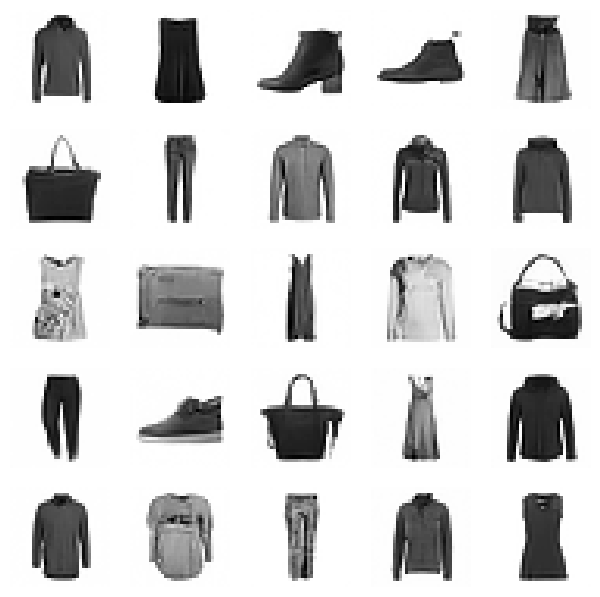

In [34]:
s = (samples[-1]*2)#.clamp(-1,1)
show_images(s[:25], imsize=1.5)
print(ie.fid(s),ie.kid(s))

 ## Triangular noise

In [35]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    t = np.random.triangular(0, 0.5, 1, (n,)) * n_steps
    t = torch.tensor(t, dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt() * x0 + (1 - ᾱ_t).sqrt() * ε
    return (xt, t.to(device)), ε

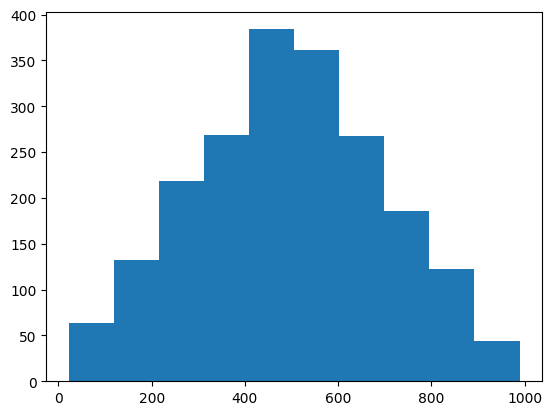

In [36]:
(xt, t), ε = noisify(xb, abar)
plt.hist(t);